<a href="https://colab.research.google.com/github/rukmals/ColabProject/blob/master/gender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! wget https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar

--2020-04-11 13:28:22--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar’

wiki_crop.tar       100%[===================>] 773.73M  24.4MB/s    in 32s     

2020-04-11 13:28:54 (24.4 MB/s) - ‘wiki_crop.tar’ saved [811315200/811315200]



In [0]:
! tar -xf wiki_crop.tar

In [0]:
import scipy.io
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import tensorflow as tf

import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from tensorflow.keras.layers import Conv2D, AveragePooling2D
from tensorflow.keras.models import Model, Sequential

from sklearn.model_selection import train_test_split

from keras import metrics

from tensorflow.keras.models import model_from_json
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
mat = scipy.io.loadmat('wiki_crop/wiki.mat')

In [0]:

columns = ["dob", "photo_taken", "full_path", "gender", "name", "face_location", "face_score", "second_face_score"]

In [0]:
instances = mat['wiki'][0][0][0].shape[1]

df = pd.DataFrame(index = range(0,instances), columns = columns)

In [0]:
for i in mat:
    if i == "wiki":
        current_array = mat[i][0][0]
        for j in range(len(current_array)):
            #print(columns[j],": ",current_array[j])
            df[columns[j]] = pd.DataFrame(current_array[j][0])

In [0]:
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum)) \
           + timedelta(days=int(days)) \
           + timedelta(hours=int(hours)) \
           + timedelta(minutes=int(minutes)) \
           + timedelta(seconds=round(seconds)) \
           - timedelta(days=366)
    
    return exact_date.year

In [0]:
df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)

In [0]:
df['age'] = df['photo_taken'] - df['date_of_birth']

In [0]:

#remove pictures does not include face
df = df[df['face_score'] != -np.inf]

#some pictures include more than one face, remove them
df = df[df['second_face_score'].isna()]

#check threshold
df = df[df['face_score'] >= 3]

In [0]:
df = df[df['age'] <= 100]

#some guys seem to be unborn in the data set
df = df[df['age'] > 0]

In [0]:
df=df.drop(["dob", "photo_taken", "name", "face_location", "face_score", "second_face_score","date_of_birth"],axis=1)

,full_path,gender,age
0,[17/10000217_1981-05-05_2009.jpg],1.0,28
2,[12/100012_1948-07-03_2008.jpg],1.0,60
4,[16/10002116_1971-05-31_2012.jpg],0.0,41
5,[02/10002702_1960-11-09_2012.jpg],0.0,52
6,[41/10003541_1937-09-27_1971.jpg],1.0,34


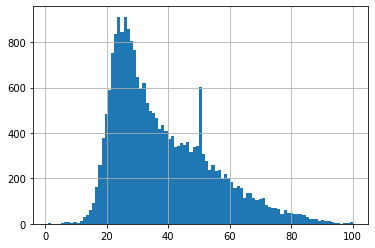

In [0]:
histogram = df['age'].hist(bins=df['age'].nunique())
df.head()

In [0]:
df=df.dropna()

In [0]:
df['gender'].unique()
df.shape

(22138, 3)

In [0]:
import cv2
train=[]
for i in df['full_path']:
  img=cv2.imread("wiki_crop/%s" % i[0])
  img=cv2.resize(img,(224,224))
  train.append(img)

In [0]:
train = np.array(train).reshape(22138,224,224,3)
train.shape

(22138, 224, 224, 3)

In [0]:
len(train)

22138

In [0]:
target=df['gender']


In [0]:
# datagen_kwargs = dict(rescale=1./255, validation_split=.20)
# valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
# train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

In [0]:
train=train.astype('float32')
train/=255

In [0]:
train_x, test_x, train_y, test_y = train_test_split(train, target, test_size=0.2)
  

In [0]:
# train_generator=train_datagen.fit(train_x)
# valid_generator=valid_datagen.fit(test_x)

In [0]:
train_y = tf.keras.utils.to_categorical(train_y, 2)
test_y = tf.keras.utils.to_categorical(test_y, 2)

In [0]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K

base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [0]:
model.compile(loss='categorical_crossentropy'
                  , optimizer=tf.keras.optimizers.Adam()
                  #, optimizer = sgd
                  , metrics=['accuracy']
                 )

In [0]:
model.fit(train_x, train_y,
          batch_size=32,
          epochs=2,
          verbose=1,
          validation_data=(test_x,test_y ))

NameError: ignored

In [0]:
FLOWERS_SAVED_MODEL = "saved_models/gender"
tf.saved_model.save(model, FLOWERS_SAVED_MODEL)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_models/gender/assets


In [0]:
flowers_model = hub.load(FLOWERS_SAVED_MODEL)
print(flowers_model)

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7f358e1fc860>


In [0]:
!mkdir "tflite_models"

In [0]:
TFLITE_MODEL = "tflite_models/gender.tflite"
TFLITE_QUANT_MODEL = "tflite_models/gender_quant.tflite"
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

In [0]:

run_model = tf.function(lambda x : flowers_model(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)

print("TFLite models and their sizes:")
!ls "tflite_models" -lh

TFLite models and their sizes:
total 17M
-rw-r--r-- 1 root root 3.5M May 27 07:53 gender_quant.tflite
-rw-r--r-- 1 root root  14M May 27 07:53 gender.tflite


INFO:tensorflow:Assets written to: saved_models/age/assets


INFO:tensorflow:Assets written to: saved_models/age/assets


<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject object at 0x7fdb22b42b38>


In [0]:
tflite_interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)

input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])

print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

== Input details ==
name: x
shape: [  1 224 224   3]
type: <class 'numpy.float32'>

== Output details ==
name: Identity
shape: [  1 101]
type: <class 'numpy.float32'>
